In [1]:
# SECTION 1: Setup and Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pystac_client
import planetary_computer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset

<Asset href=abfs://gridmet/gridmet.zarr>

In [3]:
import xarray as xr
ds = xr.open_dataset(
    asset.href,
    engine="zarr",
    storage_options=asset.extra_fields.get("xarray:storage_options", {}),
    **asset.extra_fields.get("xarray:open_kwargs", {})
)
ds

<xarray.Dataset> Size: 597GB
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 2B 3
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 123kB 19...
Data variables:
    air_temperature                            (time, lat, lon) float32 50GB ...
    burning_index_g                            (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 50GB ...
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 50GB ...
    mean_vapor_pressure_deficit                (time, lat, lon) float32 50GB ...
    potential_evapotranspiration               (time, lat, lon) float32 50GB ...
    precipitation_amount                       (time, lat, lon) float32 50GB ...
    relative_humidity                          (time, lat, lon) float32 50GB ...
    specific_humidity                          (time, lat, lon) float32 50GB ...
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 50GB ...
    wind_from_direction                        (time, lat, lon) float32 50GB ...
    wind_speed                                 (time, lat, lon) float32 50GB ...
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

<Axes: >

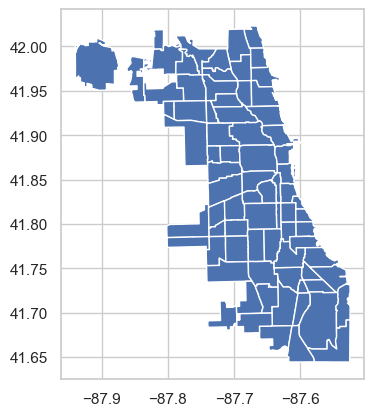

In [4]:
import geopandas as gpd

# Load California boundary from local GeoJSON file
california = gpd.read_file(r"C:\Users\tomas\Downloads\Boundaries - Community Areas.geojson")

# Ensure it's in WGS84 coordinate reference system
california = california.to_crs("EPSG:4326")

# Plot to confirm
california.plot()

In [5]:
VARIABLES = [
    "air_temperature", "burning_index_g", "dead_fuel_moisture_100hr",
    "dead_fuel_moisture_1000hr", "mean_vapor_pressure_deficit", "potential_evapotranspiration",
    "precipitation_amount", "relative_humidity", "specific_humidity",
    "surface_downwelling_shortwave_flux_in_air", "wind_from_direction", "wind_speed"
]

In [6]:
ds=ds[VARIABLES].sel(time=slice("2017-01-01", None))

In [7]:
ds.rio.write_crs("EPSG:4326", inplace=True)

<xarray.Dataset> Size: 57GB
Dimensions:                                    (time: 1461, lat: 585, lon: 1386)
Coordinates:
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * time                                       (time) datetime64[ns] 12kB 201...
    crs                                        int32 4B 0
Data variables:
    air_temperature                            (time, lat, lon) float32 5GB ...
    burning_index_g                            (time, lat, lon) float32 5GB ...
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 5GB ...
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 5GB ...
    mean_vapor_pressure_deficit                (time, lat, lon) float32 5GB ...
    potential_evapotranspiration               (time, lat, lon) float32 5GB ...
    precipitation_amount                       (time, lat, lon) float32 5GB ...
    relative_humidity                          (time, lat, lon) float32 5GB ...
    specific_humidity                          (time, lat, lon) float32 5GB ...
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 5GB ...
    wind_from_direction                        (time, lat, lon) float32 5GB ...
    wind_speed                                 (time, lat, lon) float32 5GB ...
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [8]:
from shapely.geometry import box

# Get bounding box from GeoDataFrame
minx, miny, maxx, maxy = california.total_bounds
ds_california = ds.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [9]:
daily_avg = ds_california.mean(dim=["lat", "lon"])
weekly_avg = daily_avg.resample(time = "1W").mean()

In [10]:
weekly_ds = ds_california.resample(time="1W").mean()

In [11]:
# Mean over lat/lon to get a time-series per variable
weekly_avg = weekly_ds.mean(dim=["lat", "lon"])

In [12]:
df_weekly = weekly_ds.to_dataframe().dropna().reset_index()
df_weekly


,time,lat,lon,air_temperature,burning_index_g,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed,crs
0,2017-01-01,42.025,-87.933333,267.000000,17.00,18.100000,22.600000,0.2300,0.800,0.000,45.799999,0.002340,88.800003,154.00,2.800,0
1,2017-01-01,42.025,-87.891667,267.100006,18.00,17.700001,22.400000,0.2400,0.800,0.000,45.600002,0.002340,86.900002,154.00,2.800,0
2,2017-01-01,42.025,-87.850000,267.399994,18.00,17.400000,22.300001,0.2500,0.800,0.000,44.900002,0.002340,84.800003,156.00,2.800,0
3,2017-01-01,42.025,-87.808333,267.500000,19.00,17.200001,21.200001,0.2400,0.800,0.000,45.400002,0.002340,82.700005,156.00,2.800,0
4,2017-01-01,42.025,-87.766667,267.500000,21.00,17.200001,20.300001,0.2400,0.800,0.000,45.700001,0.002350,81.099998,156.00,2.900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21205,2021-01-03,41.650,-87.683333,266.575012,19.50,17.650000,17.125000,0.1325,0.975,3.100,58.825005,0.002418,79.200005,239.25,4.175,0
21206,2021-01-03,41.650,-87.641667,266.575012,19.25,17.875002,17.450001,0.1275,0.950,2.975,60.000000,0.002437,78.175003,239.25,4.200,0
21207,2021-01-03,41.650,-87.600000,266.475006,18.75,18.250000,17.799999,0.1225,0.925,3.075,60.949997,0.002455,77.150002,238.25,4.200,0
21208,2021-01-03,41.650,-87.558333,266.349976,18.75,18.550001,18.000000,0.1150,0.875,3.150,61.700001,0.002465,76.125000,238.25,4.200,0


In [13]:
lat_spacing = float(weekly_ds.lat[1] - weekly_ds.lat[0])
lon_spacing = float(weekly_ds.lon[1] - weekly_ds.lon[0])

print(f"Lat spacing: {lat_spacing:.4f}°")
print(f"Lon spacing: {lon_spacing:.4f}°")

Lat spacing: -0.0417°
Lon spacing: 0.0417°


In [14]:
import numpy as np

lat_deg = float(weekly_ds.lat.mean())
lat_km = 111.0 * lat_spacing
lon_km = 111.0 * np.cos(np.radians(lat_deg)) * lon_spacing

print(f"Pixel size ≈ {lat_km:.2f} km (N-S) × {lon_km:.2f} km (E-W)")

Pixel size ≈ -4.63 km (N-S) × 3.45 km (E-W)


Text(0.5, 1.0, 'Feature Correlation Heatmap')

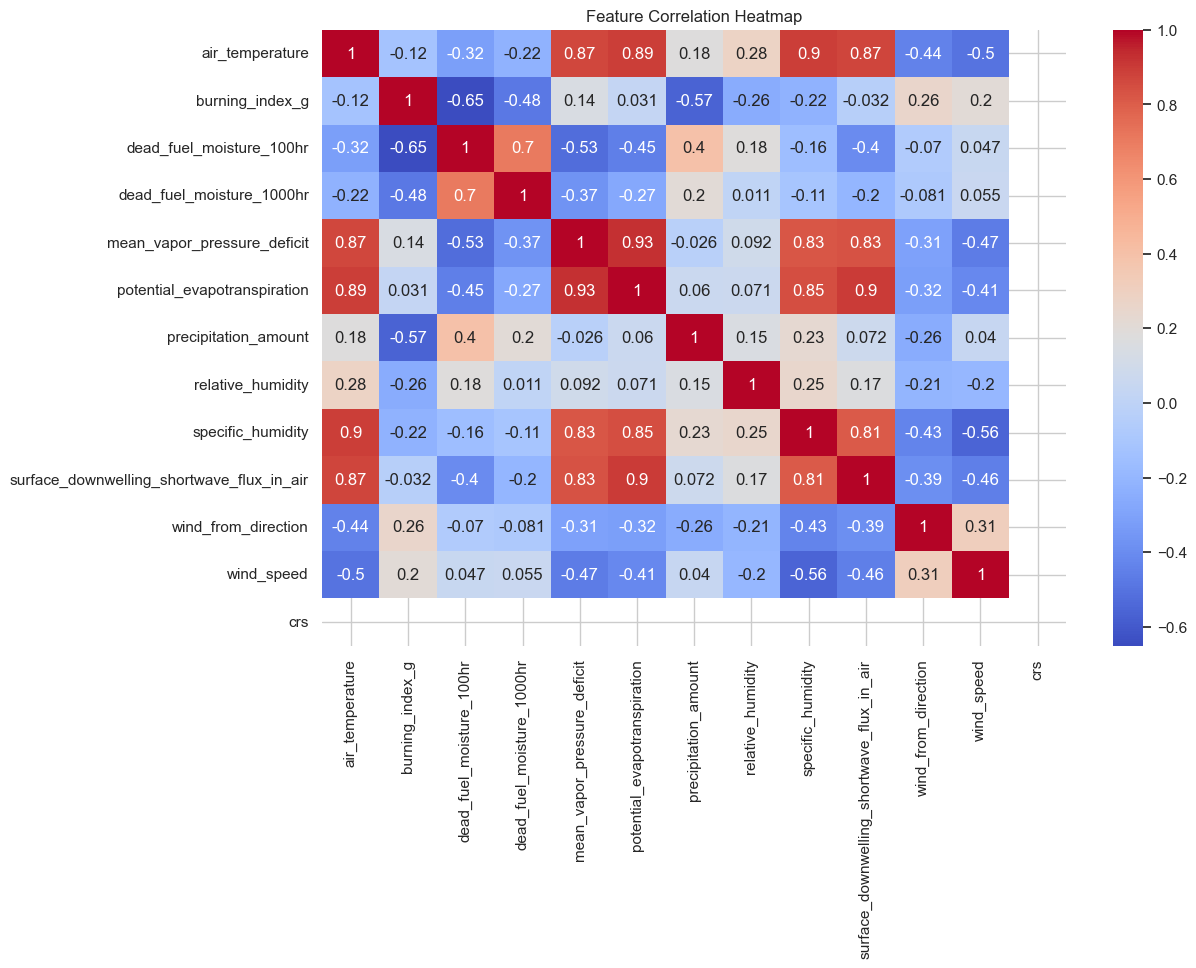

In [15]:
import seaborn as sns

# Only numeric features
numeric_cols = df_weekly.select_dtypes(include='number').drop(columns=['lat', 'lon'])
corr = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")

In [16]:
import numpy as np

corr_matrix = numeric_cols.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
numeric_cols = numeric_cols.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")

Dropped columns: ['mean_vapor_pressure_deficit', 'potential_evapotranspiration', 'specific_humidity', 'surface_downwelling_shortwave_flux_in_air']


In [17]:
df_weekly

,time,lat,lon,air_temperature,burning_index_g,dead_fuel_moisture_100hr,dead_fuel_moisture_1000hr,mean_vapor_pressure_deficit,potential_evapotranspiration,precipitation_amount,relative_humidity,specific_humidity,surface_downwelling_shortwave_flux_in_air,wind_from_direction,wind_speed,crs
0,2017-01-01,42.025,-87.933333,267.000000,17.00,18.100000,22.600000,0.2300,0.800,0.000,45.799999,0.002340,88.800003,154.00,2.800,0
1,2017-01-01,42.025,-87.891667,267.100006,18.00,17.700001,22.400000,0.2400,0.800,0.000,45.600002,0.002340,86.900002,154.00,2.800,0
2,2017-01-01,42.025,-87.850000,267.399994,18.00,17.400000,22.300001,0.2500,0.800,0.000,44.900002,0.002340,84.800003,156.00,2.800,0
3,2017-01-01,42.025,-87.808333,267.500000,19.00,17.200001,21.200001,0.2400,0.800,0.000,45.400002,0.002340,82.700005,156.00,2.800,0
4,2017-01-01,42.025,-87.766667,267.500000,21.00,17.200001,20.300001,0.2400,0.800,0.000,45.700001,0.002350,81.099998,156.00,2.900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21205,2021-01-03,41.650,-87.683333,266.575012,19.50,17.650000,17.125000,0.1325,0.975,3.100,58.825005,0.002418,79.200005,239.25,4.175,0
21206,2021-01-03,41.650,-87.641667,266.575012,19.25,17.875002,17.450001,0.1275,0.950,2.975,60.000000,0.002437,78.175003,239.25,4.200,0
21207,2021-01-03,41.650,-87.600000,266.475006,18.75,18.250000,17.799999,0.1225,0.925,3.075,60.949997,0.002455,77.150002,238.25,4.200,0
21208,2021-01-03,41.650,-87.558333,266.349976,18.75,18.550001,18.000000,0.1150,0.875,3.150,61.700001,0.002465,76.125000,238.25,4.200,0


In [18]:
grouped_features = {
    'temp_humidity': ['air_temperature', 'specific_humidity', 'relative_humidity'],
    'fuel_moisture': ['dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr'],
    'wind': ['wind_speed', 'wind_from_direction', 'mean_vapor_pressure_deficit'],
    'precip_solar': ['precipitation_amount', 'surface_downwelling_shortwave_flux_in_air'],
    'fire_risk': ['burning_index_g']  # already a single feature, but we can still scale it
}

In [19]:
aggregated_df = df_weekly[['time', 'lat', 'lon']].copy()

In [20]:
# Apply PCA to each group
for group_name, features in grouped_features.items():
    scaler = StandardScaler()
    pca = PCA(n_components=1)

    # Ensure no NaNs in the selected features
    group_data = df_weekly[features].fillna(0)
    group_scaled = scaler.fit_transform(group_data)
    aggregated_df[group_name] = pca.fit_transform(group_scaled)

In [22]:
aggregated_df

,time,lat,lon,temp_humidity,fuel_moisture,wind,precip_solar,fire_risk
0,2017-01-01,42.025,-87.933333,-2.037876,2.270894,-1.039932,-1.340654,-0.313744
1,2017-01-01,42.025,-87.891667,-2.036126,2.094775,-1.055762,-1.356632,-0.184824
2,2017-01-01,42.025,-87.850000,-2.032780,1.979593,-1.045932,-1.374293,-0.184824
3,2017-01-01,42.025,-87.808333,-2.017713,1.553394,-1.030102,-1.391954,-0.055904
4,2017-01-01,42.025,-87.766667,-2.010375,1.249070,-0.967897,-1.405410,0.201937
...,...,...,...,...,...,...,...,...
21205,2021-01-03,41.650,-87.683333,-1.801049,0.297530,1.063470,-0.846182,0.008556
21206,2021-01-03,41.650,-87.641667,-1.775434,0.468453,1.086936,-0.877996,-0.023674
21207,2021-01-03,41.650,-87.600000,-1.760061,0.688511,1.082021,-0.868062,-0.088134
21208,2021-01-03,41.650,-87.558333,-1.751107,0.837508,1.093894,-0.862765,-0.088134


In [23]:
import torch
from torch.utils.data import Dataset

class WeatherPredictionDataset(Dataset):
    def __init__(self, df, seq_len=8, pred_len=1):
        self.seq_len = seq_len
        self.pred_len = pred_len
        df = df.sort_values(['lat', 'lon', 'time']).reset_index(drop=True)
        self.groups = df.groupby(['lat', 'lon'])
        self.X, self.y = [], []

        for (lat, lon), group in self.groups:
            features = group.drop(columns=['time', 'lat', 'lon']).values
            for i in range(len(features) - seq_len - pred_len + 1):
                self.X.append(features[i:i+seq_len])
                self.y.append(features[i+seq_len:i+seq_len+pred_len])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
import torch.nn as nn

In [25]:
class TransformerForecastModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, n_heads=4, n_layers=2, dropout=0.1, pred_len=1):
        super().__init__()
        self.embedding = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.predictor = nn.Linear(hidden_dim, feature_dim * pred_len)
        self.feature_dim = feature_dim
        self.pred_len = pred_len

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x[:, -1, :]  # last time step
        out = self.predictor(x)
        return out.view(-1, self.pred_len, self.feature_dim)

In [26]:
def compute_risk_scores(model, dataloader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            preds = model(X_batch)
            mse = ((preds - y_batch) ** 2).mean(dim=(1, 2))  # Mean over pred_len and features
            all_scores.extend(mse.numpy())

    return all_scores

In [27]:
def train_and_score(df, seq_len=8, pred_len=1, epochs=10, batch_size=64):
    feature_cols = [col for col in df.columns if col not in ['time', 'lat', 'lon']]
    feature_dim = len(feature_cols)

    dataset = WeatherPredictionDataset(df, seq_len, pred_len)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = TransformerForecastModel(feature_dim=feature_dim, pred_len=pred_len)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    print("Training model...")
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    print("Scoring risk...")
    risk_scores = compute_risk_scores(model, loader)
    return risk_scores, model

In [28]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [29]:
risk_scores, model = train_and_score(
    aggregated_df,    # your prepared DataFrame
    seq_len=8,        # how many weeks to look back
    pred_len=1,       # how many weeks to predict
    epochs=10,        # number of training epochs
    batch_size=64     # tune based on your memory
)

C:\Users\tomas\AppData\Local\Temp\ipykernel_24376\3420252493.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


Training model...
Epoch 1/10 - Loss: 0.2980
Epoch 2/10 - Loss: 0.1558
Epoch 3/10 - Loss: 0.0797
Epoch 4/10 - Loss: 0.1150
Epoch 5/10 - Loss: 0.0817
Epoch 6/10 - Loss: 0.0789
Epoch 7/10 - Loss: 0.0832
Epoch 8/10 - Loss: 0.0705
Epoch 9/10 - Loss: 0.0611
Epoch 10/10 - Loss: 0.0647
Scoring risk...


In [30]:
# Extract aligned coordinate/time metadata
dataset = WeatherPredictionDataset(aggregated_df, seq_len=8, pred_len=1)
coords = []
for (lat, lon), group in aggregated_df.groupby(['lat', 'lon']):
    for i in range(len(group) - 8 - 1 + 1):  # seq_len + pred_len - 1
        coords.append((group.iloc[i+8]['time'], lat, lon))

# Rebuild DataFrame
risk_df = pd.DataFrame(coords, columns=["time", "lat", "lon"])
risk_df["risk_score"] = risk_scores

In [31]:
risk_df

,time,lat,lon,risk_score
0,2017-02-26,41.650,-87.933333,0.027011
1,2017-03-05,41.650,-87.933333,0.009600
2,2017-03-12,41.650,-87.933333,0.056645
3,2017-03-19,41.650,-87.933333,0.016939
4,2017-03-26,41.650,-87.933333,0.036591
...,...,...,...,...
20397,2020-12-06,42.025,-87.600000,0.018324
20398,2020-12-13,42.025,-87.600000,0.033957
20399,2020-12-20,42.025,-87.600000,0.125021
20400,2020-12-27,42.025,-87.600000,0.006527


In [32]:
from sklearn.preprocessing import MinMaxScaler

# Assume you have a column called 'risk_score' in your risk_by_coord dataframe
scaler = MinMaxScaler(feature_range=(1, 10))

risk_df["risk_score_scaled_1_10"] = scaler.fit_transform(
    risk_df[["risk_score"]]  # or whatever your best score is
)

In [34]:
# Compute percentile rank per week
risk_by_coord['risk_percentile'] = risk_df.groupby('time')['risk_score_scaled_1_10'].rank(pct=True)

# Compute risk trend (percent change over time, averaged) per location
risk_by_coord['risk_trend'] = (
    risk_df.groupby(['lat', 'lon'])['risk_score']
    .transform(lambda x: x.pct_change().mean())
)

# Composite score: combines percentile and trend
risk_by_coord['composite_score'] = (
    0.7 * risk_df['risk_percentile'] +
    0.3 * risk_df['risk_trend'].fillna(0).clip(lower=-1, upper=1)
)

NameError: name 'risk_by_coord' is not defined

In [ ]:
risk_by_coord

In [ ]:
risk_by_coord['composite_score'].mean()